<a href="https://colab.research.google.com/github/sazad007/Grid-Demand-Forecasting/blob/main/24h_Demand_Forecasting_using_realtime_data_from_power_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Conv1D
from tensorflow.keras.models import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
n_feature = 1
seq_length = 24*7
forecast_horizon = 24

In [ ]:
data = pd.read_csv('power-gen-load.csv')

#drop all duplicates
data.drop_duplicates(inplace=True)

#remove first row because it starts a new day that don't have full 24h cycle data
data.drop(0, inplace=True)
print(data.shape)

(94321, 16)


In [ ]:
#parse data column into pandas datetime and remove any invalid date
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y', errors='coerce')
data = data[data['Date'].notna()]

In [ ]:
#remove any invalid data from time column
allowed_vals = ['24:00:00','00:00:00', '23:00:00', '22:00:00', '21:00:00', '20:00:00', '19:00:00', '18:00:00', '17:00:00', '16:00:00', '15:00:00', '14:00:00', '13:00:00', '12:00:00', '11:00:00', '10:00:00', '09:00:00', '08:00:00', '07:00:00', '06:00:00', '05:00:00', '04:00:00', '03:00:00', '02:00:00', '01:00:00', '9:00:00', '8:00:00', '7:00:00', '6:00:00', '5:00:00', '4:00:00', '3:00:00', '2:00:00', '1:00:00']
data = data[data['Time'].isin(allowed_vals)]

#this dataset uses 24:00:00 that is not supported by pd.
#so, replace 24:00:00 by 00:00:00 and increase the day column by 1
data.loc[data['Time'] == '24:00:00', 'Date'] = data.loc[data['Time'] == '24:00:00', 'Date'] + pd.Timedelta(days=1)

#padd with leading zeros because they are missing in dataset
data.loc[data['Time'].str.len() < 8, 'Time'] = '0' + data.loc[data['Time'].str.len() < 8, 'Time']
data.loc[data['Time'] == '24:00:00', 'Time'] = '00:00:00'

#make new datetime column with date + time
data['dateTime'] = data['Date'].astype(str) + ' ' + data['Time'].astype(str)
data['dateTime'] = pd.to_datetime(data['dateTime'], format = '%Y-%m-%d %H:%M:%S')
print(data.iloc[:50, 0:4])

         Date      Time  Generation(MW)  Demand(MW)
1  2025-08-28  23:00:00         15241.0       15241
2  2025-08-28  22:00:00         15117.0       15117
3  2025-08-28  21:00:00         15243.0       15243
4  2025-08-28  20:00:00         15278.0       15278
6  2025-08-28  19:00:00         14992.0       14992
7  2025-08-28  18:00:00         13060.0       13060
8  2025-08-28  17:00:00         13522.0       13522
9  2025-08-28  16:00:00         13853.0       13853
10 2025-08-28  15:00:00         14081.0       14081
11 2025-08-28  14:00:00         13990.0       13990
12 2025-08-28  13:00:00         14234.0       14270
13 2025-08-28  12:00:00         13862.0       13900
14 2025-08-28  11:00:00         13471.0       13510
15 2025-08-28  10:00:00         13202.0       13250
16 2025-08-28  09:00:00         13078.0       13140
17 2025-08-28  08:00:00         12858.0       12858
18 2025-08-28  07:00:00         13117.0       13117
19 2025-08-28  06:00:00         13130.0       13130
20 2025-08-2

In [ ]:
#use data from 2024
formatted_data = data[['dateTime', 'Date', 'Demand(MW)']]
formatted_data = formatted_data[formatted_data['Date'].dt.year >= 2024]

#drop any duplicates from dateTime column
formatted_data = formatted_data.drop_duplicates(subset=['dateTime'])
#formatted_data = formatted_data.groupby('Date').filter(lambda x: len(x) == 24)

#index the data using datetime and set dataset freq hourly
formatted_data = formatted_data.set_index('dateTime')
formatted_data = formatted_data.asfreq('h')
#this generates hourly gapped timeseries with NaNs if the rows don't exist

In [ ]:
#replace outliers with NaN and then replace with interpolate()
q75 = formatted_data['Demand(MW)'].quantile(0.80)
q25 = formatted_data['Demand(MW)'].quantile(0.20)
iqr = q75 - q25
upp = q75 + 1.5*iqr
loww = q25 - 1.5*iqr

formatted_data.loc[(formatted_data['Demand(MW)'] > upp) | (formatted_data['Demand(MW)'] < loww), 'Demand(MW)'] = np.nan

#replace missing values
formatted_data['Demand(MW)'] = formatted_data['Demand(MW)'].interpolate(method='time')

In [ ]:
print(formatted_data.shape)

(14544, 2)


In [ ]:
ddd = formatted_data.groupby('Date').size().sort_index(ascending=True)
print(ddd)

Date
2024-01-01    24
2024-01-02    24
2024-01-03    24
2024-01-04    24
2024-01-05    24
              ..
2025-08-24    24
2025-08-25    24
2025-08-26    24
2025-08-27    24
2025-08-28    24
Length: 606, dtype: int64


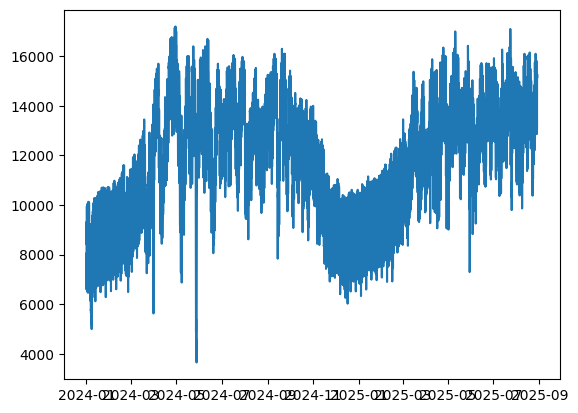

In [ ]:
plt.plot(formatted_data.index, formatted_data['Demand(MW)'])
plt.show()

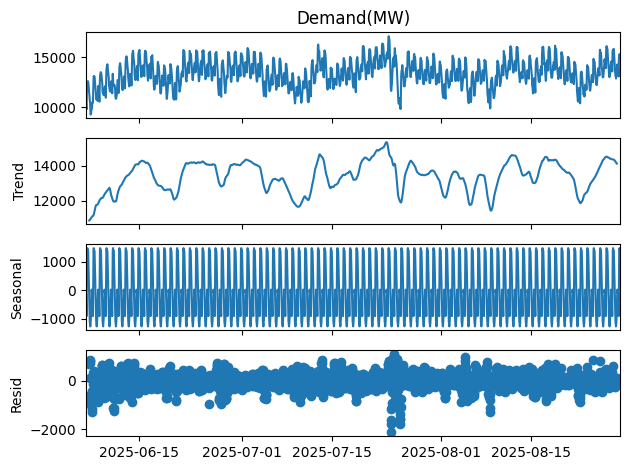

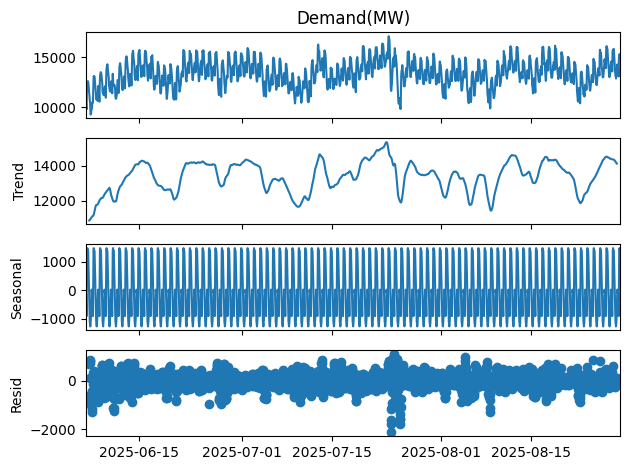

In [ ]:
ssd = seasonal_decompose(formatted_data['Demand(MW)'][-2000:], model='additive', period=24)
ssd.plot()

In [ ]:
#keep last 24h data for prediction
forecast_data = formatted_data[-seq_length:][['Demand(MW)']]

#use rest for training
training_data = formatted_data[:-seq_length][['Demand(MW)']]

#split into train test
split = 0.8
index = int(len(training_data)*split)

train = training_data[:index]
test = training_data[index:]

#scale data
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
forecast_data = scaler.transform(forecast_data)

print(train.shape)
print(test.shape)
print(forecast_data.shape)

(11500, 1)
(2876, 1)
(168, 1)


In [ ]:
#generate timeseries for training
#X = train
#X = TimeseriesGenerator(X, X, seq_length, batch_size = 64)

def generate_seq(train):
  X, y = [], []
  for i in range(len(train) - seq_length - forecast_horizon +1):
    X.append(train[i:i+seq_length, 0])
    y.append(train[i+seq_length:i+seq_length+forecast_horizon, 0])
  return np.array(X), np.array(y)

X, y = generate_seq(train)
X = X.reshape(X.shape[0], X.shape[1], n_feature)

In [ ]:
X_test, y_test = generate_seq(test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_feature)

In [ ]:
#seq2seq model
model = Sequential([
    LSTM(128, input_shape=(seq_length, n_feature), return_sequences=True), #True because another LSTM layer is present
    Dropout(0.4),
    LSTM(64, return_sequences=False), #False because no more LSTM layer is present
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(forecast_horizon * n_feature)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(X, y, epochs=50, batch_size=64, callbacks=[lr_scheduler, early_stop], validation_data=(X_test, y_test))

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0769 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0121 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0101 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0074 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0061 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0057 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0053 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0051 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0049 - val_loss: 0.0060 - learning_rate: 0.0010
E

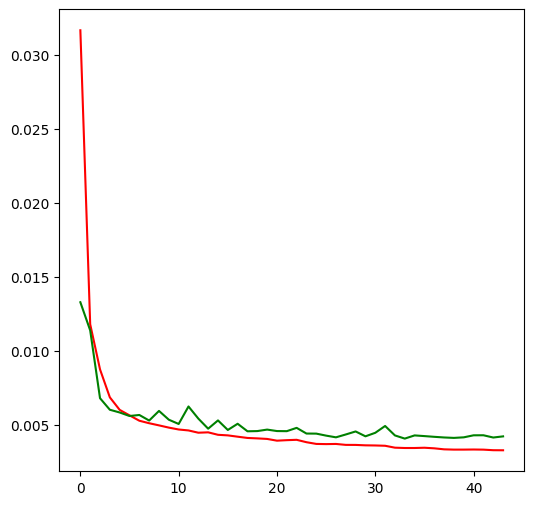

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.show()

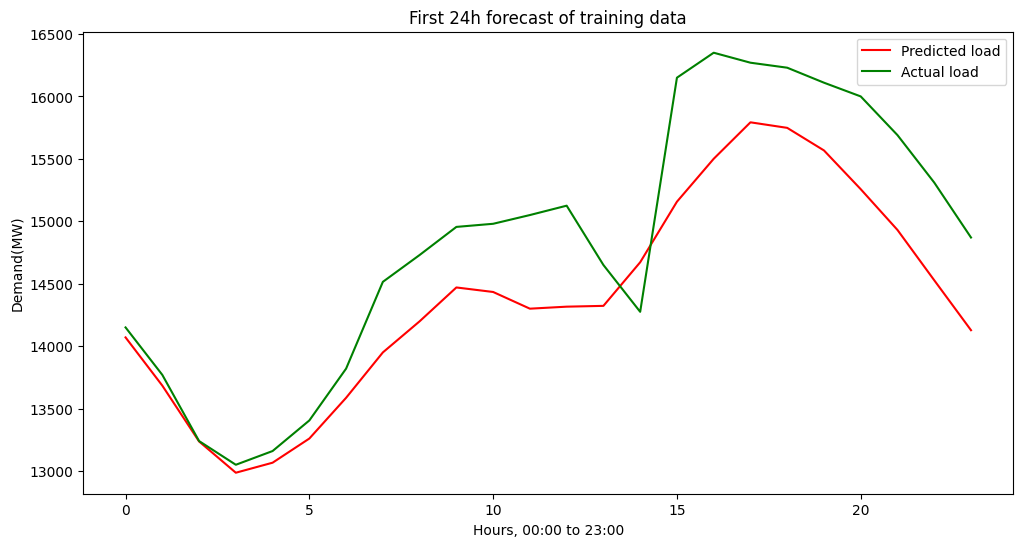

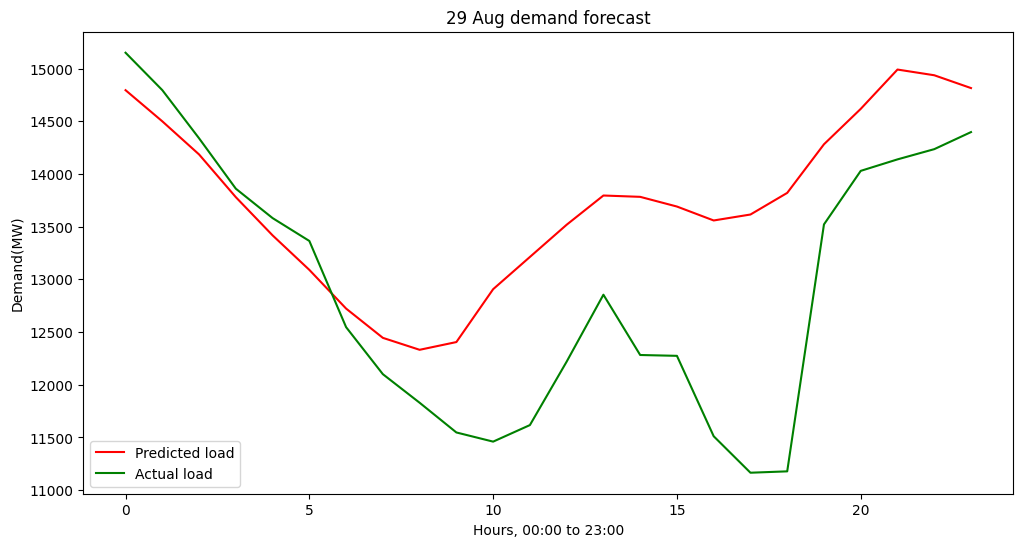

In [ ]:
#compare prediction with test data
init_seq = np.array(train[-seq_length:])
init_seq = init_seq.reshape(1, seq_length, n_feature)
y_pred = model(init_seq, training=False)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(test[0:forecast_horizon])

plt.figure(figsize=(12,6))
plt.plot(range(forecast_horizon), y_pred[0], color='red', label = 'Predicted load')
plt.plot(range(forecast_horizon), y_true.reshape(-1), color='green', label = 'Actual load')
plt.xlabel('Hours, 00:00 to 23:00')
plt.ylabel('Demand(MW)')
plt.title('First 24h forecast of training data')
plt.legend()
plt.show()


init_seq = np.array(forecast_data)
init_seq = init_seq.reshape(1, seq_length, n_feature)
y_pred = model(init_seq, training=False)
y_pred = scaler.inverse_transform(y_pred)

#real data from 29-Aug-2025
y_true = [15150, 14795, 14338, 13860, 13581, 13364, 12546, 12100, 11829, 11547, 11460, 11617, 12219, 12854, 12282, 12274, 11511, 11165, 11178, 13521, 14029, 14138, 14235, 14397]

plt.figure(figsize=(12,6))
plt.plot(range(forecast_horizon), y_pred[0], color='red', label = 'Predicted load')
plt.plot(range(forecast_horizon), y_true, color='green', label = 'Actual load')
plt.xlabel('Hours, 00:00 to 23:00')
plt.ylabel('Demand(MW)')
plt.title('29 Aug demand forecast')
plt.legend()
plt.show()

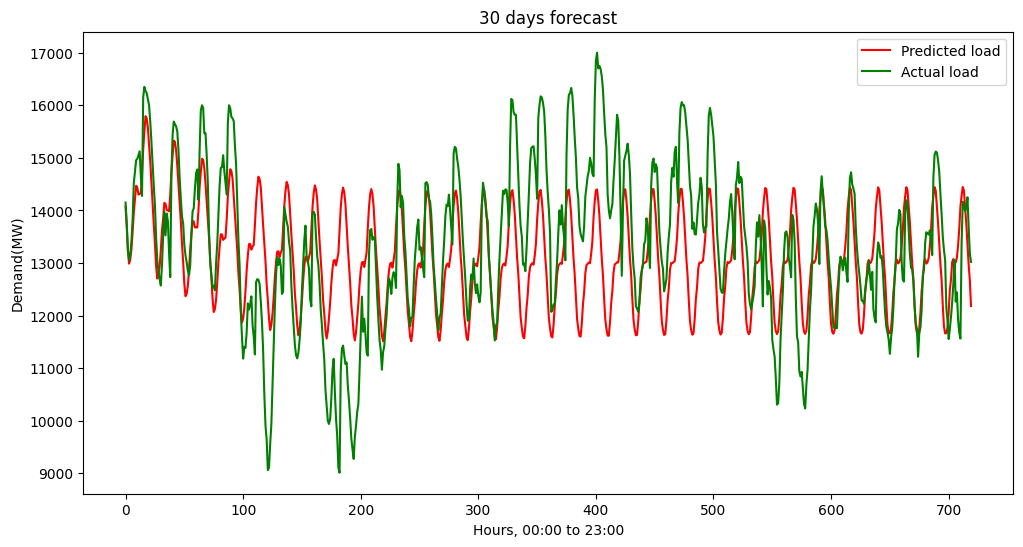

In [ ]:
#generate a months forecast and compare with test data
days = 30
preds = []
init_seq = np.array(train[-seq_length:])
init_seq = init_seq.reshape(1, seq_length, n_feature)

for _ in range(days):
  y_pred = model(init_seq, training=False)
  preds.append(y_pred[0])
  i_flat = init_seq.reshape(-1)
  i_flat = i_flat[forecast_horizon:]
  i_flat = np.append(i_flat, np.array(y_pred[0]).reshape(-1))
  init_seq = i_flat.reshape(1, seq_length, n_feature)

y_pred = scaler.inverse_transform(preds).reshape(-1)
y_true = scaler.inverse_transform(test[0:forecast_horizon*days])

plt.figure(figsize=(12,6))
plt.plot(range(days*24), y_pred, color='red', label = 'Predicted load')
plt.plot(range(days*24), y_true, color='green', label = 'Actual load')
plt.xlabel('Hours, 00:00 to 23:00')
plt.ylabel('Demand(MW)')
plt.title('30 days forecast')
plt.legend()
plt.show()